In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Read in data, explore, and clean

In [95]:
df = pd.read_csv('./data/large_train_sample.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,<=50K


In [96]:
df.shape

(32561, 14)

In [97]:
df['capital-gain'].describe()

count    32561.000000
mean      1077.648844
std       7385.292085
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64

In [98]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
wage              0
dtype: int64

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  wage            32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [100]:
df['education'].value_counts()[:10]

 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
Name: education, dtype: int64

In [101]:
df['occupation'].value_counts()[:10]

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
Name: occupation, dtype: int64

In [31]:
df['native-country'].value_counts()[:10]

 United-States    29170
 Mexico             643
 ?                  583
 Philippines        198
 Germany            137
 Canada             121
 Puerto-Rico        114
 El-Salvador        106
 India              100
 Cuba                95
Name: native-country, dtype: int64

In [32]:
df['wage'][0]

' <=50K'

In [102]:
# Binarize target column
df['wage'] = df['wage'].map({' <=50K':0, ' >50K':1})

In [34]:
df['marital-status'].value_counts()

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64

In [35]:
# Identify number of question marks in column
df['native-country'].value_counts()[df['native-country'].value_counts().index == ' ?']

 ?    583
Name: native-country, dtype: int64

In [103]:
# Filter to question marks in column
df[df['native-country'] == ' ?']

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Male,0,0,40,?,1
38,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,Male,0,0,38,?,1
51,18,Private,226956,HS-grad,9,Never-married,Other-service,Own-child,Female,0,0,30,?,0
61,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,Male,0,0,40,?,0
93,30,Private,117747,HS-grad,9,Married-civ-spouse,Sales,Wife,Female,0,1573,35,?,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32449,44,Self-emp-inc,71556,Masters,14,Married-civ-spouse,Sales,Husband,Male,0,0,50,?,1
32469,58,Self-emp-inc,181974,Doctorate,16,Never-married,Prof-specialty,Not-in-family,Female,0,0,99,?,0
32492,42,Self-emp-not-inc,217597,HS-grad,9,Divorced,Sales,Own-child,Male,0,0,50,?,0
32510,39,Private,107302,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,Male,0,0,45,?,1


#### Question marks by column
Confirmed that missing `native-country`does not imply missing data in other columns


workclass = 1836

occupation = 1843

native-country = 583

In [37]:
df['education'].value_counts

<bound method IndexOpsMixin.value_counts of 0          Bachelors
1          Bachelors
2            HS-grad
3               11th
4          Bachelors
            ...     
32556     Assoc-acdm
32557        HS-grad
32558        HS-grad
32559        HS-grad
32560        HS-grad
Name: education, Length: 32561, dtype: object>

In [38]:
# Convert column using ordinal values
def final_ed(x):
    if 'Preschool' in x or '1st-4th' in x or '5th-6th' in x or '9th' in x or '10th' in x or '11th' in x or '7th-8th' in x or '12th' in x:
        return 1
    elif 'HS-grad' in x or 'Some-college' in x or 'Assoc-voc' in x or 'Assoc-acdm' in x or 'Prof-school' in x:
        return 2
    elif 'Bachelors' in x:
        return 3
    elif 'Masters' in x or 'Doctorate' in x:
        return 4
    else:
        return 1


df['education'] = df['education'].map(final_ed)

In [39]:
df['education'].value_counts

<bound method IndexOpsMixin.value_counts of 0        3
1        3
2        2
3        1
4        3
        ..
32556    2
32557    2
32558    2
32559    2
32560    2
Name: education, Length: 32561, dtype: int64>

In [41]:
# Dummify nominal columns
df = pd.get_dummies(df, 
                    columns=['workclass', 'marital-status', 'relationship', 'sex', 
                             'education',], 
                    drop_first=True)

In [42]:
df.shape

(32561, 32)

In [43]:
df.head().T

,0,1,2,3,4
age,39,50,38,53,28
fnlwgt,77516,83311,215646,234721,338409
education-num,13,13,9,7,13
occupation,Adm-clerical,Exec-managerial,Handlers-cleaners,Handlers-cleaners,Prof-specialty
capital-gain,2174,0,0,0,0
capital-loss,0,0,0,0,0
hours-per-week,40,13,40,40,40
native-country,United-States,United-States,United-States,United-States,Cuba
wage,0,0,0,0,0
workclass_ Federal-gov,0,0,0,0,0


In [44]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   age                                    32561 non-null  int64 
 1   fnlwgt                                 32561 non-null  int64 
 2   education-num                          32561 non-null  int64 
 3   occupation                             32561 non-null  object
 4   capital-gain                           32561 non-null  int64 
 5   capital-loss                           32561 non-null  int64 
 6   hours-per-week                         32561 non-null  int64 
 7   native-country                         32561 non-null  object
 8   wage                                   32561 non-null  int64 
 9   workclass_ Federal-gov                 32561 non-null  uint8 
 10  workclass_ Local-gov                   32561 non-null  uint8 
 11  workclass_ Neve

In [116]:
# Baseline model results
df['wage'].value_counts(normalize=True)

0    0.75919
1    0.24081
Name: wage, dtype: float64

In [45]:
# Drop columns not needed in modeling
df = df.drop(columns=['occupation', 'native-country'])

In [46]:
# Set X and y
features = df.drop(columns='wage').columns


X = df[features]
y = df['wage']

features

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov',
       'workclass_ Never-worked', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay',
       'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-spouse-absent',
       'marital-status_ Never-married', 'marital-status_ Separated',
       'marital-status_ Widowed', 'relationship_ Not-in-family',
       'relationship_ Other-relative', 'relationship_ Own-child',
       'relationship_ Unmarried', 'relationship_ Wife', 'sex_ Male',
       'education_2', 'education_3', 'education_4'],
      dtype='object')

In [49]:
# Polynomial function to expand number of features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

In [50]:
X_poly.shape

(32561, 465)

In [52]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X_poly,
                                                    y,
                                                    random_state = 42, 
                                                    stratify=y)

In [53]:
# Scale data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [54]:
# PCA to identify most useful features
pca = PCA(svd_solver='full', n_components=.95)
pca.fit(X_train_sc)
pca.components_.shape

(148, 465)

In [55]:
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 20 components): {var_exp[:20]}')

Explained variance (first 20 components): [0.05511558 0.03858865 0.03582593 0.03103888 0.02951242 0.02683129
 0.02643881 0.02576827 0.02473134 0.02420011 0.02401149 0.02375806
 0.02368658 0.02338084 0.02328689 0.02303603 0.02279049 0.02204152
 0.02063583 0.0179967 ]


In [56]:
Z_train = pca.transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

In [57]:
pd.DataFrame(Z_train).var().map(round)

0      21
1      15
2      14
3      12
4      11
       ..
143     1
144     1
145     1
146     1
147     1
Length: 148, dtype: int64

In [58]:
var_exp = pca.explained_variance_ratio_
var_exp.sum()

0.9513245457772843

In [59]:
# Adaboost with Random Forest
ada = AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=5, max_features=5, n_estimators=75)
                             ,random_state=42)
ada.fit(Z_train, y_train)

AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=5,
                                                         max_features=5,
                                                         n_estimators=75),
                   random_state=42)

In [60]:
ada.score(Z_train, y_train), ada.score(Z_test, y_test)

(0.9126126126126126, 0.8487900749293699)

In [69]:
preds = ada.predict(Z_test)
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [62]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6181
           1       0.72      0.61      0.66      1960

    accuracy                           0.85      8141
   macro avg       0.80      0.77      0.78      8141
weighted avg       0.84      0.85      0.84      8141



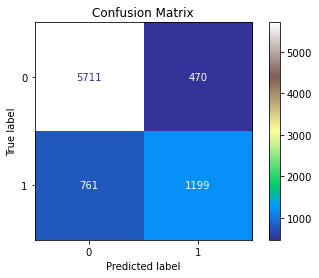

In [104]:
plot_confusion_matrix(ada, Z_test, y_test, cmap='terrain')
plt.title('Confusion Matrix', fontdict = {'fontsize':12});

In [112]:
tn, tp, fn, fp = confusion_matrix(y_test, preds).ravel()

metrics.accuracy_score(y_test, preds)
print(f'Accuracy score is: {metrics.accuracy_score(y_test, preds)}'),
print(f'Precision score is: {metrics.precision_score(y_test, preds)}'),
print(f'Recall score is: {metrics.recall_score(y_test, preds)}'),
print(f'Specificity score is: {tn / (tn + fp)}')

Accuracy score is: 0.8487900749293699
Precision score is: 0.7183942480527262
Recall score is: 0.611734693877551
Specificity score is: 0.8264833574529667


#### Read in test CSV for Kaggle submission
Modify it to match initial CSV

In [82]:
df_sub = pd.read_csv('./data/test_data.csv')

In [83]:
df_sub.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

In [84]:
df_sub.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.767459,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,13.849187,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


In [85]:
df_sub['education'] = df_sub['education'].map(final_ed)
df_sub.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,1,7,Never-married,Machine-op-inspct,Own-child,Male,0,0,40,United-States
1,38,Private,89814,2,9,Married-civ-spouse,Farming-fishing,Husband,Male,0,0,50,United-States
2,28,Local-gov,336951,2,12,Married-civ-spouse,Protective-serv,Husband,Male,0,0,40,United-States
3,44,Private,160323,2,10,Married-civ-spouse,Machine-op-inspct,Husband,Male,7688,0,40,United-States
4,18,?,103497,2,10,Never-married,?,Own-child,Female,0,0,30,United-States


In [86]:
df_sub = pd.get_dummies(df_sub, 
                        columns=['workclass', 'marital-status', 'relationship', 'sex', 
                             'education',], 
                        drop_first=True)

In [87]:
df_sub = df_sub.drop(columns=['occupation', 'native-country'])

In [88]:
X_sub_poly = poly.transform(df_sub)

In [89]:
X_sub_poly_sc = ss.transform(X_sub_poly)

In [90]:
Z_sub = pca.transform(X_sub_poly_sc)

In [91]:
sub_pred = ada.predict(Z_sub)

In [92]:
df_sub['wage'] = sub_pred
df_sub['wage'].head()

0    0
1    0
2    0
3    1
4    0
Name: wage, dtype: int64

In [93]:
submission = df_sub[['wage']]
submission

,wage
0,0
1,0
2,0
3,1
4,0
...,...
16276,0
16277,0
16278,1
16279,0


In [94]:
submission.to_csv('./team1_hackathon_sub1.csv', index=False)